To obtain the dataset needed for this notebook, execute the `gen_face_dataset.py` script in this directory. It will download the wider_face dataset and generate a face classification dataset from it in the `face_dataset` directory.

You have to have the Python packages `Pillow`, `tqdm`, and `datasets` by Huggingface installed for the script to work

For the duplicate removal (not necessary, but good practice) you also have to have the `fdupes` program installed

In [1]:
Float = Float32; # Define datatype to be used for all operations

using MLUtils, MLDataUtils, MLDatasets, Images, Augmentor, Flux, ProgressMeter, Plots, BenchmarkTools
using CUDA
using Printf
using BSON: @save, @load
using SymPy
using Base.Iterators
using CSV, DataFrames

ProgressMeter.ijulia_behavior(:clear)

false

# Load Dataset

In [2]:
"""Bring a matrix of RGB into the format of a tensor with the color channels as the last dimention"""
convert_img(img) = Float.(permutedims(channelview(img), (2,3,1)))

"""Given a vector of RGB matrices, converts everything into a single tensor with 
the color channel as the third and the samples as the last dimention"""
function convert_imgs(imgs)
    nb_imgs = length(imgs)
    width, height = size(imgs[1])
    tensor = Array{Float, 4}(undef, height, width, 3, nb_imgs)
    @showprogress 1 " Converting images" for (i, img) in enumerate(imgs)
        tensor[:,:,:,i] .= convert_img(img)
    end
    tensor
end

"""Loads the face dataset"""
function load_image_dataset(folder::String; max_samples::Int)    
    classes = Set{String}()
    images = []
    classes = []
    
    files = readdir(folder)
    @showprogress 1 "Loading images" for file in files[1:min(length(files), max_samples)]
        if endswith(file, ".png")
            class = split(split(file, "_cls")[2], ".")[1]
            image = load(joinpath(folder, file))
            push!(images, image)
            push!(classes, parse(Int, class))
        end
    end
    
    class_dict = Dict("0" => 0, "1" => 1)
    
    return convert_imgs(images), classes, class_dict
end

load_image_dataset

#### Load, shuffle, split and prepare dataset

In [3]:
X, Y, class_dict = load_image_dataset("face_dataset", max_samples=40000)
(Xtrain, ytrain), (Xtest, ytest) = MLUtils.splitobs(MLUtils.shuffleobs((X, Y)), at=0.96)

# Transform labels to 1-of-k coding

Ytrain = convertlabel(LabelEnc.OneOfK{Float}, ytrain, 0:1)
Ytest = convertlabel(LabelEnc.OneOfK{Float}, ytest, 0:1)

summary(Ytrain), summary(Ytest)

Loading images 100%|█████████████████████████████████████| Time: 0:00:27
 Converting images 100%|█████████████████████████████████| Time: 0:00:16


("2×24086 Matrix{Float32}", "2×1004 Matrix{Float32}")

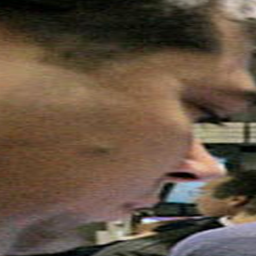

In [4]:
colorview(RGB, StackedView(Xtrain[:,:,1,1], Xtrain[:,:,2,1], Xtrain[:,:,3,1]))

## Set up Data Augmentation

In [5]:
augmentpipeline = Rotate(LinRange(-25,25,10)) |>
    Zoom(0.8:0.05:1.2) |> 
    ShearX(-20:20) |> 
    ShearY(-20:20) |> 
    #ElasticDistortion(5) |> 
    CropSize(256,256) |>
    ColorJitter()

6-step Augmentor.ImmutablePipeline:
 1.) Rotate by θ ∈ LinRange{Float64}(-25.0, 25.0, 10) degree
 2.) Zoom by I ∈ {0.8×0.8, 0.85×0.85, 0.9×0.9, 0.95×0.95, 1.0×1.0, 1.05×1.05, 1.1×1.1, 1.15×1.15, 1.2×1.2}
 3.) ShearX by ϕ ∈ -20:20 degree
 4.) ShearY by ψ ∈ -20:20 degree
 5.) Crop a 256×256 window around the center
 6.) Color jitter with coffecients α=0.8:0.1:1.2 and β=-0.2:0.1:0.2 (w.r.t. max. intensity)

In [6]:
function augment_imgs(imgs)
    height, width, channels, nb_imgs = size(imgs)
    tensor = Array{Float, 4}(undef, height, width, channels, nb_imgs)
    
    Threads.@threads for i in 1:nb_imgs
        rgb_image = colorview(RGB, StackedView(imgs[:,:,1,i], imgs[:,:,2,i], imgs[:,:,3,i]))
        augmented = augment(rgb_image, augmentpipeline)
        tensor[:,:,:,i] .= convert_img(augmented)
    end
    
    return tensor
end

augment_imgs (generic function with 1 method)

,,,,

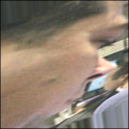
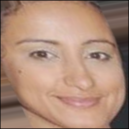
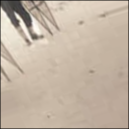
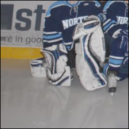
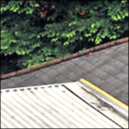

In [7]:
tmp = augment_imgs(Xtrain[:,:,:,1:10]);
[colorview(RGB, StackedView(tmp[:,:,1,i], tmp[:,:,2,i], tmp[:,:,3,i])) for i in 1:5]

# Define Neural Network Architecture

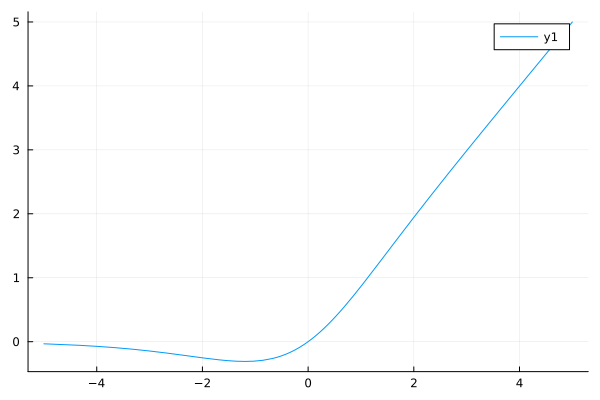

In [8]:
softplus(x) = log.(1 .+ exp.(x))
mish(x) = x .* tanh.(softplus.(x))
plot(mish)

In [9]:
model = Chain(
    Conv((7, 7), 3 => 16, stride=6),
    BatchNorm(16, mish),
    Conv((3, 3), 16 => 32, stride=2),
    BatchNorm(32, mish),
    Conv((3, 3), 32 => 32, mish),
    BatchNorm(32, mish),
    Conv((3, 3), 32 => 32, mish),
    BatchNorm(32, mish),
    MeanPool((2, 2)),
    Conv((3, 3), 32 => 48, mish),
    BatchNorm(48, mish),
    Conv((3, 3), 48 => 64, mish),
    BatchNorm(64, mish),
    MeanPool((2, 2)),
    Flux.flatten,
    Dense(256, 128),
    Dense(128, 32),
    Dense(32, 2)
    )|>gpu

Chain(
  Conv((7, 7), 3 => 16, stride=6),      # 2_368 parameters
  BatchNorm(16, mish),                  # 32 parameters, plus 32
  Conv((3, 3), 16 => 32, stride=2),     # 4_640 parameters
  BatchNorm(32, mish),                  # 64 parameters, plus 64
  Conv((3, 3), 32 => 32, mish),         # 9_248 parameters
  BatchNorm(32, mish),                  # 64 parameters, plus 64
  Conv((3, 3), 32 => 32, mish),         # 9_248 parameters
  BatchNorm(32, mish),                  # 64 parameters, plus 64
  MeanPool((2, 2)),
  Conv((3, 3), 32 => 48, mish),         # 13_872 parameters
  BatchNorm(48, mish),                  # 96 parameters, plus 96
  Conv((3, 3), 48 => 64, mish),         # 27_712 parameters
  BatchNorm(64, mish),                  # 128 parameters, plus 128
  MeanPool((2, 2)),
  Flux.flatten,
  Dense(256 => 128),                    # 32_896 parameters
  Dense(128 => 32),                     # 4_128 parameters
  Dense(32 => 2),                       # 66 parameters
)         # To

In [11]:
loss(x, y) = Flux.Losses.logitcrossentropy(model(x), y)
accuracy(x,y) = sum(y' .== (c.I[1]-1 for c in argmax(model(x), dims=1)))/length(y)

accuracy (generic function with 1 method)

# Train Neural Network

In [12]:
loss(gpu(collect(Xtest)), gpu(Ytest))

0.6930184f0

In [13]:
function train_batch(x, y, loss, opt, params, epochs; batchsize=128)
    gpu_Xtest = collect(Xtest) |> gpu
    gpu_Ytest = Ytest |> gpu
    gpu_ytest = ytest |> gpu
    gpu_train_Xtest = x[:,:,:, 1:128] |> gpu
    gpu_train_Ytest = y[:, 1:128] |> gpu
    p = Progress(epochs, showspeed=true)
    for epoch in 1:epochs
        data = MLUtils.eachobs(MLUtils.shuffleobs((x, y)), batchsize=batchsize)
        batch_p = Progress(length(data), showspeed=true)
        for (i,batch) in enumerate(data)
            aug_imgs = augment_imgs(batch[1])
            batch = (gpu(aug_imgs), gpu(batch[2]))
            Flux.train!(loss, params, [batch], opt)
            #trainloss = loss(gpu_train_Xtest, gpu_train_Ytest)
            #testloss = loss(gpu_Xtest, gpu_Ytest)
            #testaccuracy = accuracy(gpu_Xtest, ytest)
            #ProgressMeter.next!(batch_p; showvalues = [(:testloss, testloss), (:testaccuracy, testaccuracy), (:trainloss, trainloss)])
        end
        trainloss = loss(gpu_train_Xtest, gpu_train_Ytest)
        testaccuracy = accuracy(gpu_Xtest, ytest)
        println(testaccuracy)
        testloss = loss(gpu_Xtest, gpu_Ytest)
        ProgressMeter.next!(p; showvalues = [(:testloss, testloss), (:testaccuracy, testaccuracy), (:trainloss, trainloss)])
    end
end

train_batch (generic function with 1 method)

In [ ]:
train_batch(Xtrain, Ytrain, loss, RAdam(0.00001), Flux.params(model), 5; batchsize=64)

### Save or Load the model so we don't have to train every time again

In [237]:
model = cpu(model);

In [238]:
@save "faces_large_90acc.bson" model

In [15]:
@load "faces_large_90acc.bson" model

# Define Record Type for Formula Extraction

We now define a data type that we will send through the network instead of a floating point number. The new data type wraps another data type (e.g. a float) but also records everything that happens to it and generates a formula for the value that it wraps while it is manipulated.

We can then send a matrix of instances of this data type through the network and the output values will not only be the correct neuron outputs, but also a formula of how we got to this result

In [16]:
"""
Recursively joins strings and Arrays of String
"""
function joinrecurse(a)
    if typeof(a) <: AbstractString
        return a
    end
    return join([joinrecurse(i) for i in a])
end

joinrecurse

In [17]:
struct RecordFormula{T<:Real} <: Number
    val::T
    formula::Vector{Any}
end

RecordFormula(v::T, f::S) where{T<:Real, S} = RecordFormula{T}(v, f)
RecordFormula{S}(v::T) where {S, T<:Real} = RecordFormula{S}(S(v), [string(v)])
RecordFormula(v::T) where {T<:Real} = RecordFormula{T}(v, [string(v)])
RecordFormula(v::Bool) = RecordFormula{Int}(Int(v))
val(r::RecordFormula) = r.val
formula(r::RecordFormula) = joinrecurse(r.formula)
Base.Pair(r::RecordFormula) = Pair(formula(r)=>val(r))

Base.similar(a::Array{T}, m::Int) where {T<:RecordFormula} = zeros(T, m)
Base.similar(a::AbstractArray{T}, dims::Base.DimOrInd...) where {T<:RecordFormula} = zeros(T, Base.to_shape(dims))
Base.similar(a::Array{T}, dims::Dims{N}) where {T<:RecordFormula,N} = zeros(T, dims)
Base.similar(a::AbstractArray, ::Type{T}, dims::Base.DimOrInd...) where {T<:RecordFormula} = zeros(T, Base.to_shape(dims))

Base.typemin(t::Type{RecordFormula{T}}) where {T} = typemin(T)
Base.typemin(x::RecordFormula{T}) where {T} = typemin(T)

recordtostring(r::RecordFormula) = formula(r)*";"*@sprintf("%.20g", val(r))

Base.convert(::Type{RecordFormula{T}}, v::T) where {T} = RecordFormula{T}(v, [string(v)])
Base.convert(::Type{RecordFormula{S}}, v::RecordFormula{T}) where {S, T} = RecordFormula{S}(S(val(v)), v.formula)
Base.convert(::Type{RecordFormula{T}}, x::Number) where {T} = RecordFormula(x)
Base.promote_rule(::Type, ::Type{RecordFormula{T}}) where {T} = RecordFormula{T}
Base.promote_rule(::Type{RecordFormula{S}}, ::Type{RecordFormula{T}}) where {S,T} = RecordFormula{promote_type(S,T)}
Base.promote_rule(::Type{Bool}, ::Type{RecordFormula{T}}) where {T} = RecordFormula{T}

Base.:(==)(a::RecordFormula, b::RecordFormula) = val(a) == val(b)

In [18]:
for op in [:*, :+, :-, :/]
    @eval begin
        function Base.$op(a::RecordFormula, b::RecordFormula)
            str = ["(", a.formula, string($op), b.formula, ")"]
            newval = $op(a.val, b.val)
            
            return RecordFormula(newval, str)
        end
    end
end

for op in [:sin, :cos, :tan, :tanh, :log, :exp, :-, :abs]
    @eval begin
        function Base.$op(a::RecordFormula)
            str = [string($op), "(", a.formula, ")"]
            newval = $op(a.val)
            
            return RecordFormula(newval, str)
        end
    end
end

In [20]:
function Base.max(a::RecordFormula, b::RecordFormula)
    v = max(val(a), val(b))
    return RecordFormula(v, ["(",formula(a)," max ", formula(b),")"])
end

Base.max(a::Real, b::RecordFormula) = max(RecordFormula(a), b)

In [21]:
function recordify(a::Array{T, 1}, name::String) where T
    res = Array{RecordFormula, 1}(size(a))
    for r in 1:size(a, 1)
        res[r] = RecordFormula(a[r], ["$(name)_$(r)_"])
    end
    return res
end

recordify (generic function with 1 method)

In [22]:
function recordify(a::Array{T, 2}, name::String) where T
    res = Array{RecordFormula, 2}(size(a))
    for c in 1:size(a, 2)
        for r in 1:size(a, 1)
            res[r,c] = RecordFormula(a[r,c], ["$(name)_$(r)_$(c)_"])
        end
    end
    return res
end

recordify (generic function with 2 methods)

In [23]:
function recordify(a::Array{T, 3}, name::String) where T
    res = Array{RecordFormula, 3}(size(a))
    for k in 1:size(a, 3), j in 1:size(a, 2), i in 1:size(a, 1)
        res[i,j,k] = RecordFormula(a[i,j,k], ["$(name)_$(i)_$(j)_$(k)_"])
    end
    return res
end

recordify (generic function with 3 methods)

In [24]:
function recordify(a::Array{T, 4}, name::String) where T
    res = Array{RecordFormula, 4}(size(a))
    for l in 1:size(a, 4), k in 1:size(a, 3), j in 1:size(a, 2), i in 1:size(a, 1)
        res[i,j,k,l] = RecordFormula(a[i,j,k,l], ["$(name)_$(i)_$(j)_$(k)_$(l)_"])
    end
    return res
end

recordify (generic function with 4 methods)

# Extract Formulas

In [25]:
"""Given the output of a layer, returns formulas for all the outputs and a new array where the formulas are replaced by intermediate variabels"""
function generate_layer_formula(layer_out, layer_prefix)
    res = copy(layer_out)
    v = @view res[:]
    formulas = []
    for i in 1:length(v)
        var_name = "$(layer_prefix)_$i"
        f = formula(v[i])
        f = replace(f, "++" => "+", "--" => "+", "+-" => "-", "-+" => "-")
        push!(formulas, "$var_name=$f")
        v[i] = RecordFormula(val(v[i]), ["$(layer_prefix)_$i"])
    end
        
    return formulas, res
end

generate_layer_formula

In [26]:
"""Given an input image, creates an input with input variable placeholders to create formulas"""
function generate_input(img)
    o = map(x->RecordFormula(x[2], ["in_$(x[1])"]), enumerate(img))
    return o
end

generate_input

In [27]:
function get_ranges_from_breaks(breaks::Vector{Int})
    ranges = [1:breaks[1]]
    for i in 2:length(breaks)
        push!(ranges, breaks[i-1]+1:breaks[i])
    end
    return ranges
end

get_ranges_from_breaks (generic function with 1 method)

In [28]:
"""Given a model and an input, returns all formulas for all the layers of it"""
function formalize_model(model, input, layerbreaks::Vector{Int})
    all_formulas = []
    max_layers = length(model)
    ranges = get_ranges_from_breaks(layerbreaks)
    @showprogress for (i, range) in enumerate(ranges)
        modelpart = model[range]
        model_out = modelpart(input)
        layer_output_name = i == length(ranges) ? "out" : "l$i" 
        formulas, input = generate_layer_formula(model_out, layer_output_name)
        push!(all_formulas, formulas)
    end
    return all_formulas
end

formalize_model(model, input) = formalize_model(model, input, collect(1:length(model)))

formalize_model (generic function with 2 methods)

In [29]:
"""Given an image, converts it to input assignments for the formulas and expected outputs"""
function convert_image(img, model)
    input = ["in_$i=$val" for (i, val) in enumerate(vec(img[:,:,:,:]))]
    model_output = model(img)
    output = ["out_$i=$val" for (i, val) in enumerate(vec(model_output))]
    return input, output
end

convert_image

In [30]:
# Display the layers in the network together with their layer numbers
model|>enumerate|>collect

18-element Vector{Tuple{Int64, Any}}:
 (1, Conv((7, 7), 3 => 16, stride=6))
 (2, BatchNorm(16, mish))
 (3, Conv((3, 3), 16 => 32, stride=2))
 (4, BatchNorm(32, mish))
 (5, Conv((3, 3), 32 => 32, mish))
 (6, BatchNorm(32, mish))
 (7, Conv((3, 3), 32 => 32, mish))
 (8, BatchNorm(32, mish))
 (9, MeanPool((2, 2)))
 (10, Conv((3, 3), 32 => 48, mish))
 (11, BatchNorm(48, mish))
 (12, Conv((3, 3), 48 => 64, mish))
 (13, BatchNorm(64, mish))
 (14, MeanPool((2, 2)))
 (15, Flux.flatten)
 (16, Dense(256 => 128))
 (17, Dense(128 => 32))
 (18, Dense(32 => 2))

In [240]:
# Generate formulas for the network using an arbitrary image as a dummy for input conversion
# Warning: This might take quite some time
model = cpu(model)
all_formulas = formalize_model(model, generate_input(Xtrain[:,:,:,1:1]), [2,4,6,9,11,14,16,17,18]);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:38


### Some code to test the correctness of the generated formulas
*Warning*: I have not tested this for such a large network since it takes very long to evaluate the formulas in this way (probably multiple days)

In [28]:
"""Given one formula and variable assignments, returns assignment for the output variable of the formula"""
function quick_eval_formula(formula)
    variable, formula = split(formula, "=")
    res = eval(Meta.parse(String(formula)))
    return "$variable=$res"
end

function eval_variables(variables)
    for v in variables
        eval(Meta.parse(v))
    end
end

"""Given one formula and variable assignments, returns assignment for the output variable of the formula"""
function quick_eval_formula(formula, input)
    eval_variables(input)
    quick_eval_formula(formula)
end

"""Evaluates all results from formulas generated from a neural network"""
function quick_eval_formulas(all_formulas, input)
    results = []
    @showprogress 1 "Evaluating Layer" for layer in all_formulas
        eval_variables(input)
        new_inpt = []
        @showprogress 1 "Evaluationg Formula" for formula in layer
            out = quick_eval_formula(formula)
            push!(new_inpt, out)
        end
        push!(results, new_inpt)
        input=new_inpt
    end
    return results
end

quick_eval_formulas

In [27]:
i, o = convert_image(Xtrain[:,:,:,10:10], model)

(["in_1=0.6784314", "in_2=0.6745098", "in_3=0.6745098", "in_4=0.6784314", "in_5=0.68235296", "in_6=0.67058825", "in_7=0.69803923", "in_8=0.68235296", "in_9=0.7137255", "in_10=0.7176471"  …  "in_196599=0.22745098", "in_196600=0.24313726", "in_196601=0.20784314", "in_196602=0.2", "in_196603=0.23529412", "in_196604=0.24313726", "in_196605=0.21960784", "in_196606=0.23137255", "in_196607=0.2", "in_196608=0.16862746"], ["out_1=-0.20865759", "out_2=0.23244801"])

In [ ]:
results = quick_eval_formulas(all_formulas, i)

In [ ]:
# Compare calculated results with expected output
zip(results[end], o)|>collect

### Generate the needed output files for the network

In [29]:
"""
Deine Funktionen müssten dann jede in einer separaten Datei sein (anstatt in einer grossen).
In der Datei dann nur die Funktion, d.h. nicht " l1_1=". Der Titel der Textdatei der 
Funktion müsste dann mit "l1_1.txt", "l1_10.txt", " l1_11.txt" usw. benannt werden bis dann 
"out_1.txt", " out_2.txt" usw.
"""
function write_formulas(all_formulas, base_dir)
    formulas = Base.Iterators.flatten(all_formulas)|>collect
    for (varname, formula) in split.(formulas, "=")
        open(joinpath(base_dir, varname*".txt"), "w") do io
            println(io, formula)
        end
    end
end

write_formulas

In [30]:
"""
Alle Variablen, die in den Funktionen verwendet werden (Deine "in_1 .. in_784"),
müssten in eine Datei, s. "paceval_CNN_variablesString.txt" durch Leerzeichen getrennt.
"""
get_input_variable_names(example_input_formulas) = first.(split.(example_input_formulas, "="))

function write_input_variable_names(example_input_formulas, filename)
    open(filename, "w") do io
        variable_names = get_input_variable_names(example_input_formulas)
        println(io, join(variable_names, " "))
    end
end

write_input_variable_names (generic function with 1 method)

In [31]:
"""
Alle Layer, die es gibt (Deine "l1_1 .. l2_16") müssten ebenfalls in eine Datei
durch Leerzeichen getrennt, und zwar in der Reihenfolge, wie Sie abgearbeitet werden.
Wenn Layer parallelisiert, werden können dann fasse diese in einer Zeile zusammen
"""
function get_layer_variable_names(all_formulas)
    result_layers = []
    for layer in all_formulas
        layer_variable_names = join(first.(split.(layer, "=")), " ")
        push!(result_layers, layer_variable_names)
    end
    result_layers
end

function write_layer_variable_names(all_formulas, filename)
    open(filename, "w") do io
        layer_variable_names = get_layer_variable_names(all_formulas)
        for layer in layer_variable_names
            println(io, layer)
        end
    end
end

write_layer_variable_names (generic function with 1 method)

In [241]:
basepath = "results"
write_formulas(all_formulas, joinpath(basepath, "formulas"))
write_input_variable_names(i, joinpath(basepath, "paceval_variablesString.txt"))
write_layer_variable_names(all_formulas, joinpath(basepath, "paceval_layerVariableNames.txt"))

### Generate Sample Files

In [242]:
"""
Deine .sample Dateien müssten nur ; 
getrennte Werte sein, s. "image01ValuesAsText.txt". 
Jede neue Pixelreihe wäre eine neue Zeile
"""
partition(v, partition_size) = reshape(v, (partition_size, :))
get_vals(v) = last.(split.(v,"="))

function write_image(img, model, base_filename)
    input, output = convert_image(img, model)
    input, output = get_vals(input), get_vals(output)
    
    width = size(img, 1)
    input = partition(input, width*3) # * 3 because we have RGB
    
    open(base_filename*".sample", "w") do io
        for i in 1:size(input,2)
            println(io, join(input[:, i], ";"))
        end
    end
    
    open(base_filename*".expected_output", "w") do io
        println(io, join(output, ";"))
    end
    
    save(base_filename*".png", colorview(RGB, StackedView(img[:,:,1,1], img[:,:,2,1], img[:,:,3,1])))
end

write_image (generic function with 1 method)

In [258]:
"""Given the test dataset and a model, collects samples for each class that are correctly predicted by the network"""
function get_correctly_predicted_samples(X, Y, model, n)
    correct = vec([c.I[1]-1 for c in argmax(model(X), dims=1)]) .== Y
    correct_X = X[:,:,:,correct]
    correct_Y = Y[correct]
    
    allcls = unique(correct_Y)
    samples = Dict(i => [] for i in allcls)
    
    isfull(d) = all(length.(values(d)) .== n)
    
    for (i, cls) in enumerate(correct_Y)
        isfull(samples) && break
        length(samples[cls]) == n && continue
        push!(samples[cls], correct_X[:,:,:,i:i])
    end
    
    return samples
end

get_correctly_predicted_samples

,
,
,
,
,
,
,
,
,
,

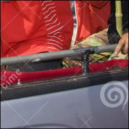
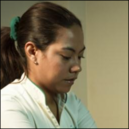
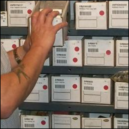
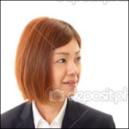
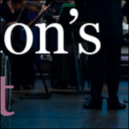
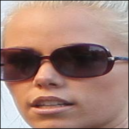
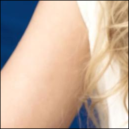
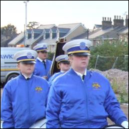
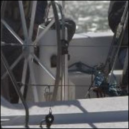
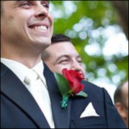
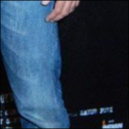
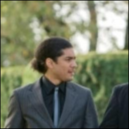
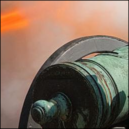
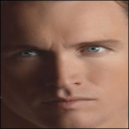
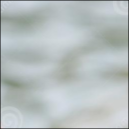
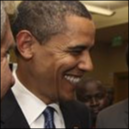
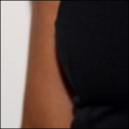
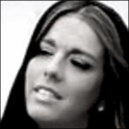
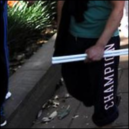
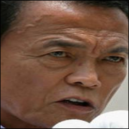

In [259]:
samples = get_correctly_predicted_samples(Xtest, ytest, model, 10)
colorview.(RGB, [StackedView(samples[j][i][:,:,1,1], samples[j][i][:,:,2,1], samples[j][i][:,:,3,1]) for i in 1:10, j in 0:1])

In [261]:
@showprogress for cls in 0:1, i in 1:10
    write_image(samples[cls][i], model, "results/faces_$(i)_cls_$(cls)")
end